## KCC Meeting metadata EDA

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

# Load JSONL file into a DataFrame
file_path = '../data/meetings/meetings_metadata.jsonl'
data = pd.read_json(file_path, lines=True)

# Show basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   web_meeting_code  2165 non-null   int64  
 1   meeting_title     2165 non-null   object 
 2   meeting_status    2165 non-null   object 
 3   committee_name    2163 non-null   object 
 4   meeting_date      2163 non-null   object 
 5   meeting_time      2163 non-null   float64
 6   agenda_items      2165 non-null   object 
 7   meeting_id        2165 non-null   object 
 8   scrape_timestamp  2165 non-null   object 
 9   error             0 non-null      float64
dtypes: float64(2), int64(1), object(7)
memory usage: 169.3+ KB


#### Loading the metadata and examining the scraping results

In [215]:
# Show the first few rows
#data.sample(1)

removing duplicates

In [216]:
# Find duplicated web_meeting_codes
duplicate_codes = data[data['web_meeting_code'].duplicated(keep=False)]

# Sort and select specific columns
duplicate_codes = duplicate_codes.sort_values('web_meeting_code')[
    ['web_meeting_code', 'scrape_timestamp', 'meeting_title', 'meeting_status', 'meeting_date']
]
duplicate_codes

,web_meeting_code,scrape_timestamp,meeting_title,meeting_status,meeting_date
157,5959,2025-05-17T00:04:13.249624,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",scheduled,None
2164,5959,2025-05-17T07:41:47.248285,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",scheduled,None
2150,7804,2025-05-17T07:21:01.252036,"Standing Advisory Council on Religious Education (SACRE) - Tuesday, 26th June, 2018 10.00 am",scheduled,2018-06-26
2155,7804,2025-05-17T07:36:45.766699,"Standing Advisory Council on Religious Education (SACRE) - Tuesday, 26th June, 2018 10.00 am",scheduled,2018-06-26
2151,7805,2025-05-17T07:21:05.818490,"Standing Advisory Council on Religious Education (SACRE) - Tuesday, 27th November, 2018 10.00 am",scheduled,2018-11-27
2156,7805,2025-05-17T07:36:49.881993,"Standing Advisory Council on Religious Education (SACRE) - Tuesday, 27th November, 2018 10.00 am",scheduled,2018-11-27


In [217]:
# Drop duplicates by web_meeting_code, keeping the last entry
#data = data.sort_values('scrape_timestamp')  # Ensure correct ordering
data = data.drop_duplicates(subset='web_meeting_code', keep='last')

In [218]:
assert data['web_meeting_code'].duplicated().sum() == 0  # Should be 0

checking for missing values

In [219]:
# Column names
print("Columns:", data.columns.tolist())

# Null values
print("\nMissing values per column:\n", data.isnull().sum())

# Unique values per column
print("\nUnique values per column:")
for col in data.columns:
    try:
        unique_count = data[col].nunique()
        print(f"{col}: {unique_count}")
    except TypeError:
        print(f"{col}: ❌ Cannot count unique values (unhashable type like list or dict)")
        
# If 'meeting_date' exists and is string, convert to datetime
if 'meeting_date' in data.columns:
    data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
    print("\nDate range:", data['meeting_date'].min(), "to", data['meeting_date'].max())

Columns: ['web_meeting_code', 'meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items', 'meeting_id', 'scrape_timestamp', 'error']

Missing values per column:
 web_meeting_code       0
meeting_title          0
meeting_status         0
committee_name         1
meeting_date           1
meeting_time           1
agenda_items           0
meeting_id             0
scrape_timestamp       0
error               2162
dtype: int64

Unique values per column:
web_meeting_code: 2162
meeting_title: 2162
meeting_status: 1
committee_name: 120
meeting_date: 1551
meeting_time: 5
agenda_items: ❌ Cannot count unique values (unhashable type like list or dict)
meeting_id: 2162
scrape_timestamp: 2162
error: 0

Date range: 2013-06-17 00:00:00 to 2026-07-23 00:00:00


In [220]:
# Convert meeting_date to datetime if not already
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Drop rows where meeting_date is NaT
data = data.dropna(subset=['meeting_date'])

Missing codes: 1839


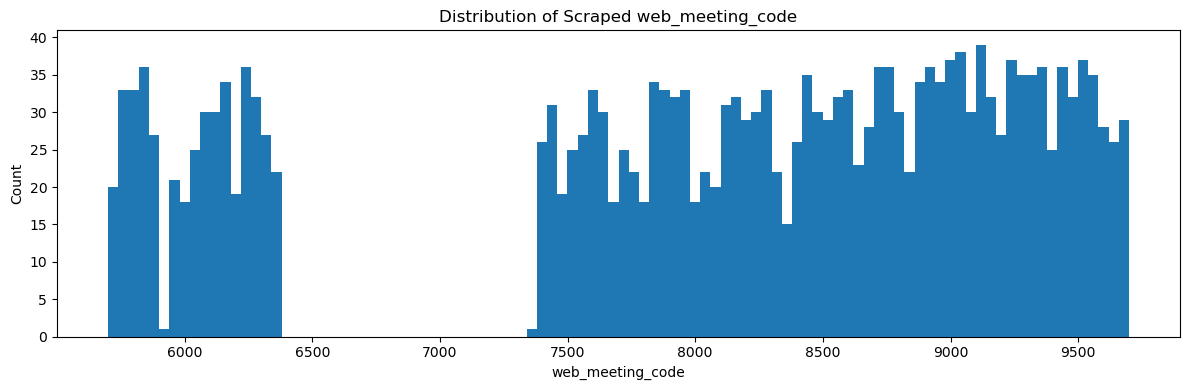

In [221]:
codes = data['web_meeting_code'].dropna().astype(int)
code_range = pd.Series(range(codes.min(), codes.max() + 1))

missing_codes = code_range[~code_range.isin(codes)]
print(f"Missing codes: {len(missing_codes)}")

plt.figure(figsize=(12, 4))
codes.plot(kind='hist', bins=100)
plt.title('Distribution of Scraped web_meeting_code')
plt.xlabel('web_meeting_code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_25755/1028356808.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_25755/1028356808.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data['scrape_minute'].min(),


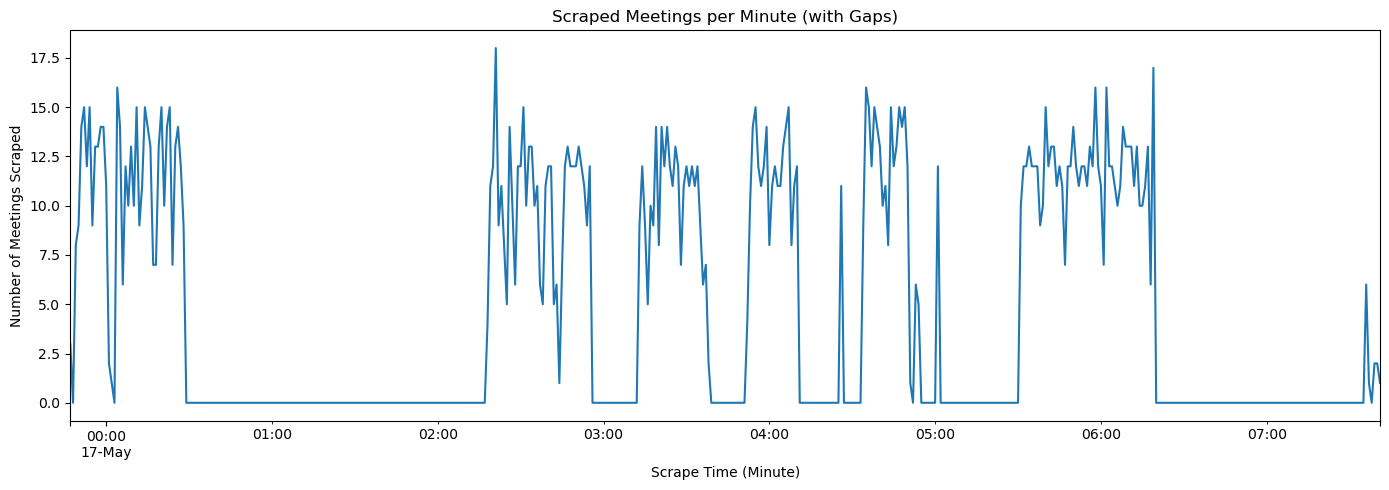

In [222]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime
data['scrape_timestamp'] = pd.to_datetime(data['scrape_timestamp'], errors='coerce')

# Floor to minute
data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')

# Count scrapes per minute
scrape_counts = data['scrape_minute'].value_counts().sort_index()

# Create full range of minutes between first and last scrape
full_range = pd.date_range(start=data['scrape_minute'].min(),
                           end=data['scrape_minute'].max(),
                           freq='T')

# Reindex with full range, fill missing with 0
scrape_counts_full = scrape_counts.reindex(full_range, fill_value=0)

# Plot
plt.figure(figsize=(14, 5))
scrape_counts_full.plot()
plt.title('Scraped Meetings per Minute (with Gaps)')
plt.xlabel('Scrape Time (Minute)')
plt.ylabel('Number of Meetings Scraped')
plt.tight_layout()
plt.show()

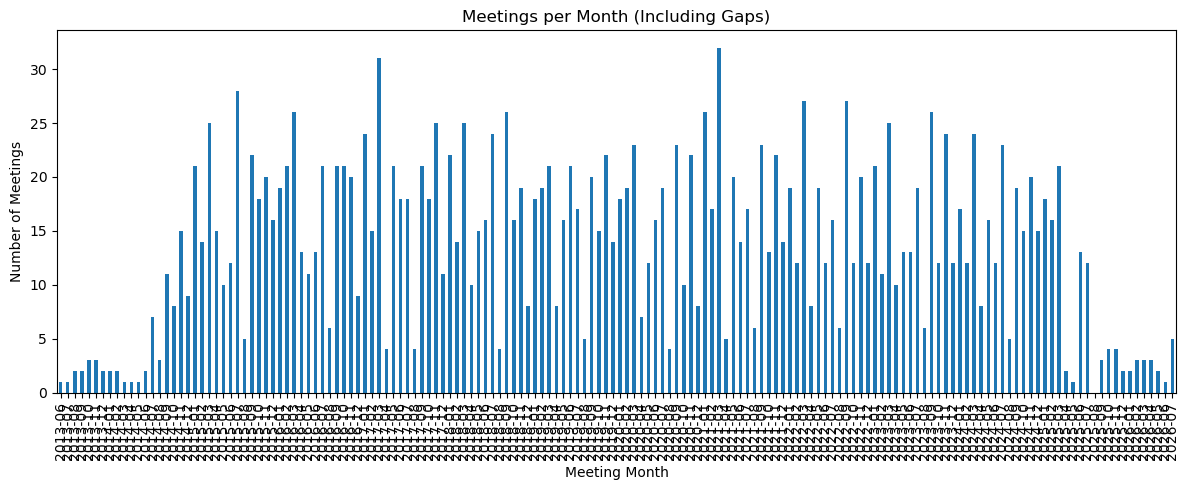

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert and extract meeting_month
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
data['meeting_month'] = data['meeting_date'].dt.to_period('M')

# Count meetings per month
monthly_counts = data['meeting_month'].value_counts().sort_index()

# Create full continuous monthly index
full_index = pd.period_range(start=data['meeting_month'].min(),
                             end=data['meeting_month'].max(),
                             freq='M')

# Reindex to ensure gaps are shown with 0s
monthly_counts_full = monthly_counts.reindex(full_index, fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
monthly_counts_full.plot(kind='bar')
plt.title('Meetings per Month (Including Gaps)')
plt.xlabel('Meeting Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [224]:
missing_months = data[data['meeting_month'].isna()]
#missing_months.sample(2)

In [225]:
missing_month_count = data['meeting_month'].isna().sum()
print(f"Missing meeting_month values: {missing_month_count}")

Missing meeting_month values: 0


In [226]:
missing_dates = data[data['meeting_date'].isna()]
missing_dates[['meeting_id', 'meeting_title', 'committee_name', 'meeting_date']]

,meeting_id,meeting_title,committee_name,meeting_date


In [227]:
# Define the fields you consider essential
essential_fields = ['meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items']

# Filter rows where web_meeting_code exists AND any essential field is missing
incomplete_rows = data[
    data['web_meeting_code'].notna() & 
    data[essential_fields].isnull().any(axis=1)
]

print(len(incomplete_rows))
incomplete_rows

0


,web_meeting_code,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,agenda_items,meeting_id,scrape_timestamp,error,scrape_minute,meeting_month


In [228]:
rerun = incomplete_rows['web_meeting_code'].to_list()
rerun

[]

In [229]:
import pandas as pd

# Ensure codes are integers and sorted
codes = data['web_meeting_code'].dropna().astype(int)
all_codes = pd.Series(range(codes.min(), codes.max() + 1))

# Identify missing codes
missing_codes = all_codes[~all_codes.isin(codes)]

# Group into consecutive ranges
gap_ranges = []
if not missing_codes.empty:
    start = prev = missing_codes.iloc[0]
    for code in missing_codes[1:]:
        if code == prev + 1:
            prev = code
        else:
            gap_ranges.append((start, prev))
            start = prev = code
    gap_ranges.append((start, prev))  # add final group

# Create DataFrame of missing ranges
missing_df = pd.DataFrame(gap_ranges, columns=['missing_start', 'missing_end'])
missing_df['missing_count'] = missing_df['missing_end'] - missing_df['missing_start'] + 1

missing_df.sort_values(by=['missing_count'], ascending=False).head(15)

,missing_start,missing_end,missing_count
84,6378,7378,1001
21,5922,5954,33
20,5894,5920,27
172,8002,8023,22
57,6187,6206,20
215,8329,8347,19
141,7765,7776,12
132,7690,7701,12
284,8838,8847,10
111,7534,7543,10


In [230]:
# Ensure meeting_date is datetime
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Create a Year-Month string column
data['year_month'] = data['meeting_date'].dt.to_period('M').astype(str)

# Group by year_month and get min, max, and count of web_meeting_code
grouped = data.groupby('year_month')['web_meeting_code'].agg(['min', 'max', 'count']).reset_index()

# Sort by month
grouped = grouped.sort_values('year_month')
grouped.tail(10)

,year_month,min,max,count
147,2025-10,9657,9695,4
148,2025-11,9679,9699,4
149,2025-12,9660,9664,2
150,2026-01,9685,9690,2
151,2026-02,9665,9696,3
152,2026-03,9661,9686,3
153,2026-04,9667,9697,3
154,2026-05,9662,9692,2
155,2026-06,9693,9693,1
156,2026-07,9663,9694,5


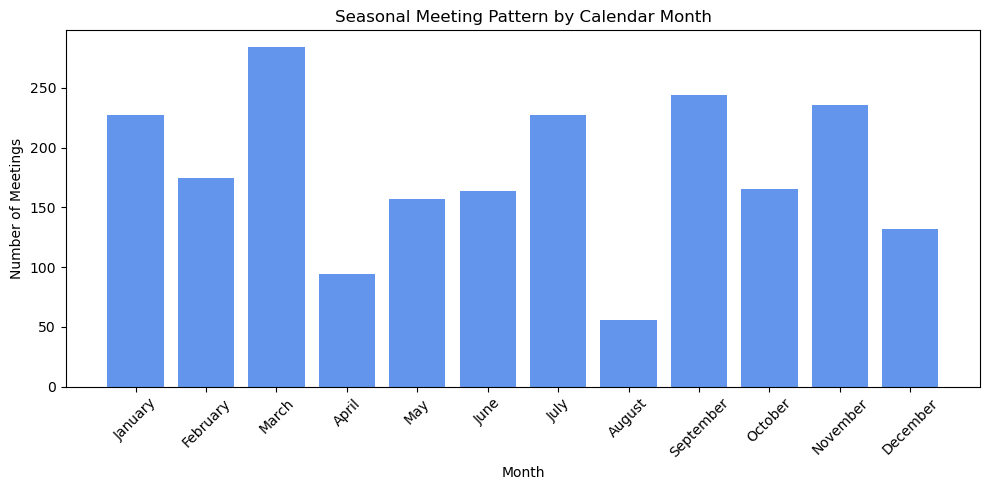

In [231]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is parsed
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Extract numeric month (1–12) and month name
data['month'] = data['meeting_date'].dt.month
data['month_name'] = data['meeting_date'].dt.month_name()

# Group by month number and count meetings
monthly_pattern = data.groupby(['month', 'month_name']).size().reset_index(name='count')

# Sort by calendar order
monthly_pattern = monthly_pattern.sort_values('month')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pattern['month_name'], monthly_pattern['count'], color='cornflowerblue')
plt.title('Seasonal Meeting Pattern by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [232]:
# Show a few non-empty agenda items
data['agenda_items'].dropna().iloc[0:1].tolist()

[[{'item_number': '1.',
   'item_title': 'Introduction/Webcast announcement',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '2.',
   'item_title': 'Apologies and Substitutes',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '3.',
   'item_title': 'Declarations of Interest by Members in items on the Agenda',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '4.',
   'item_title': 'Minutes of the meeting held on 15 January 2025PDF 106 KB',
   'item_text': 'Additional documents:',
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s129468/Minutes of the meeting held on 15 January 2025.pdf']},
  {'item_number': '5.',
   'item_title': 'Risk Management: Chief Executive and Deputy Chief Executive DepartmentsPDF 111 KB',
   'item_text': 'Additional documents:',
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s129572/Risk Management Chief Executive and Deputy Chief Executive Departments.p

#### Cleanup of junk pdf scraping results

In [233]:
import re

def clean_item_title(title):
    if isinstance(title, str):
        return re.sub(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', '', title, flags=re.IGNORECASE).strip()
    return title

def clean_agenda_items(items):
    if isinstance(items, list):
        for item in items:
            if isinstance(item, dict) and 'item_title' in item:
                item['item_title'] = clean_item_title(item['item_title'])
    return items

# Apply cleaning to the full DataFrame
data['agenda_items'] = data['agenda_items'].apply(clean_agenda_items)

#### Explore agendas

In [234]:
import pandas as pd

# Explode agenda_items so each item gets its own row
agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()

# Flatten the nested dictionaries into columns
agenda_flat = pd.json_normalize(agenda_data['agenda_items'])

# Add meeting context to each item
agenda_flat['meeting_id'] = agenda_data['meeting_id'].values
agenda_flat['committee_name'] = agenda_data['committee_name'].values
agenda_flat['meeting_date'] = agenda_data['meeting_date'].values

# Preview
agenda_flat.head()

,item_number,item_title,item_text,pdf_urls,meeting_id,committee_name,meeting_date
0,1.,Introduction/Webcast announcement,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
1,2.,Apologies and Substitutes,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
2,3.,Declarations of Interest by Members in items on the Agenda,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
3,4.,Minutes of the meeting held on 15 January 2025,Additional documents:,[https://democracy.kent.gov.uk/documents/s129468/Minutes of the meeting held on 15 January 2025.pdf],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
4,5.,Risk Management: Chief Executive and Deputy Chief Executive Departments,Additional documents:,"[https://democracy.kent.gov.uk/documents/s129572/Risk Management Chief Executive and Deputy Chief Executive Departments.pdf, https://democracy.kent.gov.uk/documents/s129573/Appendix 1 - Chief Executive Department and Deputy Chief Executive Department led Corporate Risks - .pdf]",kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05


In [235]:
agenda_flat.groupby('meeting_id').size().sort_values(ascending=False)

meeting_id
kent_cc_9334    35
kent_cc_8558    30
kent_cc_8985    26
kent_cc_8728    24
kent_cc_6131    23
                ..
kent_cc_7473     1
kent_cc_8059     1
kent_cc_8540     1
kent_cc_9105     1
kent_cc_8293     1
Length: 1770, dtype: int64

In [236]:
agenda_flat['item_title'].str.lower().str.extract(r'(\w+)')[0].value_counts().head(20)

0
appeal          1480
minutes         1317
declarations     866
apologies        751
work             407
kent             402
verbal           326
update           259
motion           238
election         237
substitutes      222
membership       215
performance      184
a                184
b                177
c                174
d                173
date             156
proposal         132
24               123
Name: count, dtype: int64

In [237]:
# Flatten the list of all pdf URLs
all_pdfs = [url for sublist in agenda_flat['pdf_urls'] if isinstance(sublist, list) for url in sublist]

# Convert to Series for easier analysis
pdf_series = pd.Series(all_pdfs)

# Count total and duplicate entries
total_pdfs = pdf_series.size
unique_pdfs = pdf_series.nunique()
duplicate_pdfs = total_pdfs - unique_pdfs

print(f"Total PDF URLs: {total_pdfs}")
print(f"Unique PDF URLs: {unique_pdfs}")
print(f"Duplicate PDF URLs: {duplicate_pdfs}")

Total PDF URLs: 14911
Unique PDF URLs: 14908
Duplicate PDF URLs: 3


### New committee cleanup approach

In [238]:
# Count occurrences of each committee_name
committee_counts = data['committee_name'].value_counts(dropna=False)

# Display result
committee_counts.tail(10)

committee_name
Lower Thames Crossing, Gravesham East Neighbourhood Forum                                                           1
Lower Thames Crossing, Gravesham Rural Forum                                                                        1
Lower Thames Crossing, Northfleet & Gravesend West Neighbourhood Forum                                              1
Parking, Gravesham East Neighbourhood Forum                                                                         1
Update on Ebbsfleet Garden City and Launch of 2016 Forum Grants, Northfleet & Gravesend West Neighbourhood Forum    1
Village Greens and Parking, Gravesham Rural Forum                                                                   1
Neighbourhood Forum Grants meeting, Northfleet & Gravesend West Neighbourhood Forum                                 1
Neighbourhood Forum Grants meeting, Gravesham East Neighbourhood Forum                                              1
Budget Meeting (Reserved Date), County Co

In [239]:
# Create DataFrame from unique non-null committee names
committee_series = data['committee_name'].dropna().unique()
df_committee_parts = pd.DataFrame({'original_name': committee_series})

# Adjust split logic
df_committee_parts['first_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[0] if ',' in x else None
)
df_committee_parts['last_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[1].strip() if ',' in x else x
)

df_committee_parts.tail(3)

,original_name,first_part,last_part
117,"Budget Meeting - reserve date, County Council",Budget Meeting - reserve date,County Council
118,"Reserve date for Plan and Precept Proposal, Kent and Medway Police and Crime Panel",Reserve date for Plan and Precept Proposal,Kent and Medway Police and Crime Panel
119,"Extraordinary, County Council",Extraordinary,County Council


In [240]:
# Define a function to extract the new committee name
def extract_last_part(name):
    if pd.isna(name):
        return name
    return name.rsplit(',', 1)[1].strip() if ',' in name else name

# Apply the transformation back to data, overwriting it
data['committee_name'] = data['committee_name'].apply(extract_last_part)

In [241]:
# Inspect datatypes and nested objects
print(data.dtypes)

# Optional: check a sample problematic row
sample = data.sample(1)
print(sample.to_dict())

web_meeting_code             int64
meeting_title               object
meeting_status              object
committee_name              object
meeting_date        datetime64[ns]
meeting_time               float64
agenda_items                object
meeting_id                  object
scrape_timestamp    datetime64[ns]
error                      float64
scrape_minute       datetime64[ns]
meeting_month            period[M]
year_month                  object
month                        int32
month_name                  object
dtype: object
{'web_meeting_code': {1178: 8488}, 'meeting_title': {1178: 'Scrutiny Committee - Friday, 27th November, 2020 10.00 am'}, 'meeting_status': {1178: 'scheduled'}, 'committee_name': {1178: 'Scrutiny Committee'}, 'meeting_date': {1178: Timestamp('2020-11-27 00:00:00')}, 'meeting_time': {1178: 1.0}, 'agenda_items': {1178: [{'item_number': '15.', 'item_title': 'Apologies and Substitutes', 'item_text': 'Minutes:\nApologies were\r\nreceived from Mr Ridgers and Mr M 

### New agenda cleanup approach

Cell 1: Clean PDF garbage from titles

In [242]:
import re

PDF_PATTERN = re.compile(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', flags=re.IGNORECASE)

agenda_flat['item_title'] = agenda_flat['item_title'].fillna('').apply(
    lambda x: PDF_PATTERN.sub('', x).strip()
)

In [261]:
# Word count from item_text
agenda_flat['word_count'] = agenda_flat['item_text'].fillna('').apply(lambda x: len(str(x).split()))

# Count number of PDFs in the list
agenda_flat['pdf_count'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [378]:
agenda_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   meeting_id      15909 non-null  object        
 1   agenda_id       15909 non-null  object        
 2   item_num_clean  15909 non-null  object        
 3   item_number     15909 non-null  object        
 4   item_title      15909 non-null  object        
 5   item_text       15909 non-null  object        
 6   pdf_urls        15909 non-null  object        
 7   committee_name  15909 non-null  object        
 8   meeting_date    15909 non-null  datetime64[ns]
 9   category        15909 non-null  object        
 10  item_seq        15909 non-null  int64         
 11  word_count      15909 non-null  int64         
 12  pdf_count       15909 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 1.6+ MB


Cell 2: Tag low-value items instead of dropping

In [339]:
# Map regex patterns to category labels
CATEGORY_PATTERNS = [
    ('apologies', re.compile(r'(?i)\bapologies\b')),
    ('declarations', re.compile(r'(?i)declaration[s]? of (interest|disclosable|inter)')),
    ('next_meeting', re.compile(r'(?i)date of next meeting')),
    ('exempt_items', re.compile(r'(?i)exempt ')),
    ('work_programme', re.compile(r'(?i)work programme')),
    ('future_meeting', re.compile(r'(?i)future meeting')),
    ('introduction', re.compile(r'(?i)^introduction')),
    ('substitutes', re.compile(r'(?i)substitutes')),
    ('questions', re.compile(r'(?i)questions')),
#    ('tributes', re.compile(r'(?i)tributes')),
    ('appeal', re.compile(r'(?i)appeal ')),
    ('minutes', re.compile(r'(?i)minutes')),
    ('appointments', re.compile(r'(?i)appointment')),
    ('restricted_items', re.compile(r'(?i)restricted')),
    ('election', re.compile(r'(?i)election of')),
    ('future_meeting', re.compile(r'(?i)Date of next')),
    ('exempt_items', re.compile(r'(?i)THE PRESS AND PUBLIC')),
    ('pay_policy', re.compile(r'(?i)Pay Policy'))
#    ('online_attendance', re.compile(r'(?i)Virtual Attendance'))
    
    
]

# Category assignment function
def classify_category(title):
    title = str(title).lower().strip()
    for label, pattern in CATEGORY_PATTERNS:
        if pattern.search(title):
            return label
    return 'discussion'

# Apply category labels to agenda items
agenda_flat['category'] = agenda_flat['item_title'].apply(classify_category)

In [364]:
agenda_flat.loc[agenda_flat['category'] == 'discussion', ['item_title', 'item_text', "word_count"]].sample(2)

,item_title,item_text,word_count
8082,To note the 2020/2021 Scrutiny Committee meeting dates,Please note the dates and times of the Scrutiny\r\nCommittee for 2020/21. All\nmeetings will begin at 10am and will be held in the\r\nCouncil Chamber.\n\n- Wednesday 12 February 2020(previously reported)\n- Thursday 16 April 2020(previously reported)\n- Tuesday 19 May\r\n2020(previously\r\nreported)\n\n-Tuesday 7 July 2020\n-Tuesday 6 October 2020\n-Friday 27 November 2020\n-Wednesday 16 December 2020\n-Friday 22 January 2021\n-Friday 26 March 2021\n-Wednesday 9 June 2021\nAdditional documents:\nMinutes:\nThe clerk advised the\r\nScrutiny Committee that the meeting dates had been circulated\r\noutside of the meeting and were provided for information and\r\nnoting.,99
15486,12.,,0


In [341]:
# Group by category and aggregate
category_counts = agenda_flat.groupby('category').agg(
    count=('category', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_pdf_count=('pdf_count', 'mean')
).reset_index()

# Optional: round for readability
category_counts['avg_word_count'] = category_counts['avg_word_count'].round(1)
category_counts['avg_pdf_count'] = category_counts['avg_pdf_count'].round(2)

category_counts

,category,count,avg_word_count,avg_pdf_count
0,apologies,754,29.9,0.00
1,appeal,1480,2.8,0.00
2,appointments,72,117.9,1.03
3,declarations,921,33.7,0.00
4,discussion,9428,198.5,1.31
5,election,238,39.6,0.01
6,exempt_items,521,79.0,0.00
7,future_meeting,94,45.6,0.03
8,introduction,92,54.2,0.14
9,minutes,1342,40.7,1.17


In [366]:
# Match titles that start with any number (with optional decimal), followed by a dot
pattern = r'^\d+(\.\d+)?\.'

matches = agenda_flat[agenda_flat['item_title'].str.match(pattern, na=False)]

# Display useful fields
matches[['agenda_id', 'item_title', 'item_text', 'meeting_id']]

,agenda_id,item_title,item_text,meeting_id
7927,kent_cc_8589_003,3.,,kent_cc_8589
7928,kent_cc_8589_002,2.,,kent_cc_8589
7929,kent_cc_8589_001,1.,,kent_cc_8589
7977,kent_cc_8588_004,4.,,kent_cc_8588
7978,kent_cc_8588_003,3.,,kent_cc_8588
...,...,...,...,...
15572,kent_cc_5837_005,5.,,kent_cc_5837
15573,kent_cc_5837_004,4.,,kent_cc_5837
15574,kent_cc_5837_003,3.,,kent_cc_5837
15575,kent_cc_5837_002,2.,,kent_cc_5837


In [379]:
matches = agenda_flat[agenda_flat['meeting_id'].str.contains('9541', na=False)]

# Display relevant fields
matches[['meeting_id', 'agenda_id', 'item_number', 'item_title', 'item_text', 'pdf_urls']]

,meeting_id,agenda_id,item_number,item_title,item_text,pdf_urls
25,kent_cc_9541,kent_cc_9541_016,D2,Kent and Medway PREVENT Duty Delivery Board Update,,[]
26,kent_cc_9541,kent_cc_9541_015,D1,Kent and Medway Domestic Abuse Related Death Reviews Update,,[]
27,kent_cc_9541,kent_cc_9541_014,014,D -RESTRICTED ITEM(S),Meeting not open to the press and public and\r\nreports not for publication\n,[]
28,kent_cc_9541,kent_cc_9541_013,C1,Dates of Future Meetings,"oThursday, 3 July 2025 at 10am\noThursday, 20 November 2025 at 10am\noTuesday, 31 March 2026 at 10am",[]
29,kent_cc_9541,kent_cc_9541_012,012,C. Matters for Information,,[]
30,kent_cc_9541,kent_cc_9541_011,B5,Kent & Medway Serious Violence Duty Update,,[https://democracy.kent.gov.uk/documents/s130387/Kent Medway Serious Violence Duty Update.pdf]
31,kent_cc_9541,kent_cc_9541_010,B4,Kent and Medway Road Safety Update,,[https://democracy.kent.gov.uk/documents/s130386/Kent and Medway Road Safety Update.pdf]
32,kent_cc_9541,kent_cc_9541_009,B3,Kent Community Safety Partnership Working Group Update,,[https://democracy.kent.gov.uk/documents/s130385/Kent Community Safety Partnership Working Group Update.pdf]
33,kent_cc_9541,kent_cc_9541_008,B2,Kent Community Safety Agreement Review and Refresh,Additional documents:,"[https://democracy.kent.gov.uk/documents/s130388/B2 - Kent Community Safety Agreement Update.pdf, https://democracy.kent.gov.uk/documents/s130389/B2 - Appendix A_DRAFT Kent Community Safety Agreement.pdf]"
34,kent_cc_9541,kent_cc_9541_007,B1,Kent Police and Crime Plan 2025-2029,,[https://democracy.kent.gov.uk/documents/s130384/B1 - Police and Crime Plan 2025-2029.pdf]


In [376]:
short_items = agenda_flat[agenda_flat['word_count'] < 5]

# Display useful columns
short_items[['agenda_id', 'item_title', 'item_text', 'word_count']].head(30)

,agenda_id,item_title,item_text,word_count
0,kent_cc_9527_012,Proportionality and Appointment to Committees and other bodies,(To Follow),2
1,kent_cc_9527_011,Report by Leader of the Council,,0
2,kent_cc_9527_010,County Council Questions,,0
3,kent_cc_9527_009,Appointment of the Leader of the Opposition,,0
4,kent_cc_9527_008,Election of the Leader of the Council,,0
5,kent_cc_9527_007,Chairman's Announcements,,0
6,kent_cc_9527_006,The Returning Officer to submit the returns of persons elected to be County Councillors until 2029,Additional documents:,2
7,kent_cc_9527_005,"Minutes of the meeting held on 13 March 2025 and, if in order, to be approved as a correct record",,0
8,kent_cc_9527_004,Declarations of Disclosable Pecuniary Interests or Other Significant Interests in items on the agenda,,0
9,kent_cc_9527_003,Apologies for Absence,,0


Cell 3: Assign fallback item numbers

In [247]:
# Replace missing or blank item_numbers with zero-padded fallback numbers
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('')

agenda_flat['item_number'] = agenda_flat.groupby('meeting_id')['item_number'].transform(
    lambda x: [item if item.strip() else f"{i+1:03d}" for i, item in enumerate(x)]
)

Cell 4: Generate agenda_id

In [248]:
# Step 1: Ensure item_number is a string
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('').astype(str).str.strip()

# Step 2: Sort by meeting_id and item_number alphabetically then numerically
agenda_flat['item_number'] = agenda_flat['item_number'].str.replace(r'[.\s]', '', regex=True)
#agenda_flat['item_number_sort'] = agenda_flat['item_number'].str.extract(r'(\d+)')[0].fillna('').astype(str).str.zfill(3)
#agenda_flat = agenda_flat.sort_values(by=['meeting_id', 'item_number', 'item_number_sort']).reset_index(drop=True)

# Step 3: Assign sequential index within each meeting after sorting
agenda_flat['item_seq'] = agenda_flat.groupby('meeting_id').cumcount() + 1
agenda_flat['item_num_clean'] = agenda_flat['item_seq'].astype(str).str.zfill(3)

# Step 4: Build clean agenda_id
agenda_flat['agenda_id'] = agenda_flat['meeting_id'] + '_' + agenda_flat['item_num_clean']

# Optional: drop the helper column
#agenda_flat.drop(columns=['item_number_sort'], inplace=True)

In [249]:
# Assign machine readable meeting time
#agenda_flat['meeting_date_ts'] = agenda_flat['meeting_date'].astype('int64') // 1_000_000  # milliseconds
#agenda_flat['meeting_date_str'] = agenda_flat['meeting_date'].dt.strftime('%Y-%m-%d')

Reorder columns in agenda_flat

In [250]:
# Desired leading columns
lead_cols = ['meeting_id','agenda_id', 'item_num_clean']#, 'meeting_date_str']

# Get the rest of the columns (preserving order but excluding the leads)
other_cols = [col for col in agenda_flat.columns if col not in lead_cols]

# Reassign agenda_flat with new column order
agenda_flat = agenda_flat[lead_cols + other_cols]

In [251]:
agenda_flat.head(5)

,meeting_id,agenda_id,item_num_clean,item_number,item_title,item_text,pdf_urls,committee_name,meeting_date,category,item_seq
0,kent_cc_9484,kent_cc_9484_001,001,1,Introduction/Webcast announcement,Additional documents:,[],Policy and Resources Cabinet Committee,2025-03-05,introduction,1
1,kent_cc_9484,kent_cc_9484_002,002,2,Apologies and Substitutes,Additional documents:,[],Policy and Resources Cabinet Committee,2025-03-05,apologies,2
2,kent_cc_9484,kent_cc_9484_003,003,3,Declarations of Interest by Members in items on the Agenda,Additional documents:,[],Policy and Resources Cabinet Committee,2025-03-05,declarations,3
3,kent_cc_9484,kent_cc_9484_004,004,4,Minutes of the meeting held on 15 January 2025,Additional documents:,[https://democracy.kent.gov.uk/documents/s129468/Minutes of the meeting held on 15 January 2025.pdf],Policy and Resources Cabinet Committee,2025-03-05,minutes,4
4,kent_cc_9484,kent_cc_9484_005,005,5,Risk Management: Chief Executive and Deputy Chief Executive Departments,Additional documents:,"[https://democracy.kent.gov.uk/documents/s129572/Risk Management Chief Executive and Deputy Chief Executive Departments.pdf, https://democracy.kent.gov.uk/documents/s129573/Appendix 1 - Chief Executive Department and Deputy Chief Executive Department led Corporate Risks - .pdf]",Policy and Resources Cabinet Committee,2025-03-05,discussion,5


In [252]:
# Sort agenda items chronologically and by item within each meeting
agenda_flat = agenda_flat.sort_values(by=['meeting_date', 'agenda_id'], ascending=False).reset_index(drop=True)

In [253]:
assert 'meeting_id' in agenda_flat.columns, "meeting_id is missing!"

Cell 5: Save to agenda_items.jsonl

In [ ]:
output_path = '../data/metadata/agenda_items.jsonl'
#agenda_flat.to_json(output_path, orient='records', lines=True)

print(f"✅ Saved {len(agenda_flat)} agenda items to: {output_path}")

✅ Saved 15909 agenda items to: ../data/metadata/agenda_items.jsonl


### Saving meetings metadata

In [255]:
# Drop agenda_items column (it is now split into agenda_flat)
meetings_df = data.drop(columns=['agenda_items'])

# Optional: sort by meeting_date
meetings_df = meetings_df.sort_values(by='meeting_date').reset_index(drop=True)

In [256]:
meetings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   web_meeting_code  2161 non-null   int64         
 1   meeting_title     2161 non-null   object        
 2   meeting_status    2161 non-null   object        
 3   committee_name    2161 non-null   object        
 4   meeting_date      2161 non-null   datetime64[ns]
 5   meeting_time      2161 non-null   float64       
 6   meeting_id        2161 non-null   object        
 7   scrape_timestamp  2161 non-null   datetime64[ns]
 8   error             0 non-null      float64       
 9   scrape_minute     2161 non-null   datetime64[ns]
 10  meeting_month     2161 non-null   period[M]     
 11  year_month        2161 non-null   object        
 12  month             2161 non-null   int32         
 13  month_name        2161 non-null   object        
dtypes: datetime64[ns](3), fl

In [257]:
# Drop helper columns
meetings_df = meetings_df.drop(columns=['meeting_month', 'month_name','month','error','scrape_minute', "year_month" ])

In [258]:
# Sort by meeting_date descending (most recent first)
meetings_df = meetings_df.sort_values(by='meeting_date', ascending=False).reset_index(drop=True)

### Saving meetings to json

In [ ]:
# Save to JSONL
meetings_path = '../data/metadata/meetings_test.jsonl'
#meetings_df.to_json(meetings_path, orient='records', lines=True)

print(f"✅ Saved {len(meetings_df)} meetings to: {meetings_path}")

✅ Saved 2161 meetings to: ../data/metadata/meetings_test.jsonl


### STOP HERE

### Committee and agenda cleaning code (legacy code block - already incorporated above) - IGNORE

In [ ]:
import pandas as pd
import re
from functools import lru_cache
import numpy as np

# Constants and compiled patterns
PDF_PATTERN = re.compile(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', flags=re.IGNORECASE)
MINUTES_PATTERN = re.compile(r'(?i)^minutes of the meeting|^minutes for')
JUNK_PATTERNS = [
    re.compile(r'(?i)apologi(es|s)'),
    re.compile(r'(?i)declaration[s]? of (interest|disclosable|inter)'),
    re.compile(r'(?i)date of next meeting'),
    re.compile(r'(?i)exempt items'),
    re.compile(r'(?i)minutes'),
    re.compile(r'(?i)^work programme'),
    re.compile(r'(?i)future meeting'),
    re.compile(r'(?i)^introduction'),
    re.compile(r'(?i)substitutes'),
    re.compile(r'(?i)questions'),
    re.compile(r'(?i)tributes'),
    re.compile(r'(?i)election of')
]

# Committee normalization setup
keyword_map = {
    'county council': 'County Council',
    'kent and medway police and crime panel': 'Kent and Medway Police and Crime Panel',
    'select committee': 'Select Committee',
    'member development': 'Member Development',
    'regulation committee appeal': 'Regulation Committee Appeal Panel (Transport)',
    'standing advisory council on religious': 'Standing Advisory Council on Religious Education (SACRE)',
    'adult social care': 'Adult Social Care Cabinet Committee',
    'pension': 'Pension Fund Committee',
    'education': "Children's, Young People and Education Cabinet Committee",
    'personnel': "Personnel Committee",
    'regulation committee member panel': 'Regulation Committee',
    "children's social care and health cabinet committee": "Children's, Young People and Education Cabinet Committee",
    'environment & transport cabinet committee': "Environment & Transport Cabinet Committee",
    'governance and audit committee': "Governance and Audit Committee",
    'nhs joint': "Kent and Medway NHS Joint Overview and Scrutiny Committee",
    'standards committee': "Standards Committee",
    'wellbeing board': "Kent Health and Wellbeing Board",
    'scrutiny committee': "Scrutiny Committee",
    'governor appointments': "Governor Appointments Panel",
    'regulation committee appeal panel': "Regulation Committee Appeal Panel (Transport)",
    "mental health guardianship": "Regulation Committee"
}

@lru_cache(maxsize=500)
def normalize_committee(name):
    if not isinstance(name, str):
        return name
    name_lower = name.lower()
    for keyword, canonical in keyword_map.items():
        if keyword in name_lower:
            return canonical
    return name

# Cleaning functions
def clean_single_item(item):
    if not isinstance(item, dict):
        return item
    return {
        **item,
        'item_title': PDF_PATTERN.sub('', item.get('item_title', '')).strip()
    }

def is_junk_item(item):
    if not isinstance(item, dict):
        return True
    title = str(item.get('item_title', '')).lower()
    return (
        not title.strip() or
        any(pattern.search(title) for pattern in JUNK_PATTERNS) or
        MINUTES_PATTERN.search(title)
    )

def filter_junk_items(items):
    if not isinstance(items, list):
        return []
    return [item for item in items if not is_junk_item(item)]

def clean_data_chunk(chunk):
    """Helper function for parallel processing"""
    return chunk.assign(agenda_items=chunk['agenda_items'].apply(filter_junk_items))

# Main cleaning pipeline
def clean_data(file_path):
    # Load data
    df = pd.read_json(file_path, lines=True)
    
    # Convert dates
    df['scrape_timestamp'] = pd.to_datetime(df['scrape_timestamp'], errors='coerce')
    df['meeting_date'] = pd.to_datetime(df['meeting_date'], errors='coerce')
    
    # Clean agenda items
    df['agenda_items'] = df['agenda_items'].apply(
        lambda x: [clean_single_item(i) for i in x] if isinstance(x, list) else x
    )
    
    # Normalize committees
    df['committee_name'] = df['committee_name'].apply(normalize_committee)
    df = df[~df['committee_name'].str.contains('forum', case=False, na=False)]
    
    # Filter junk items (sequential version - removed parallel processing)
    df['agenda_items'] = df['agenda_items'].apply(filter_junk_items)
    
    # Final filtering
    df = df[df['agenda_items'].str.len() > 0]
    valid_committees = df['committee_name'].dropna().unique()
    df = df[df['committee_name'].isin(valid_committees)]
    
    return df.reset_index(drop=True)

# View agenda items function
def get_committee_agenda_items(df, committee_name):
    committee_meetings = df[
        df['committee_name'].str.lower() == committee_name.lower()
    ].copy()
    
    if committee_meetings.empty:
        print(f"No meetings found for committee: {committee_name}")
        return pd.DataFrame()
    
    agenda_data = committee_meetings.explode('agenda_items').dropna(subset=['agenda_items'])
    agenda_flat = pd.json_normalize(agenda_data['agenda_items'])
    
    # Add meeting context
    context_cols = ['meeting_id', 'committee_name', 'meeting_date', 'meeting_title']
    for col in context_cols:
        agenda_flat[col] = agenda_data[col].values
    
    agenda_flat['num_pdfs'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    return agenda_flat.sort_values(['meeting_date', 'item_number']).reset_index(drop=True)

# Execute pipeline
if __name__ == "__main__":
    FILE_PATH = '../data/meetings/meetings_metadata.jsonl'
    
    # Clean the data
    cleaned_data = clean_data(FILE_PATH)
    
    # Example usage - view Cabinet items
    cabinet_items = get_committee_agenda_items(cleaned_data, "Governance and Audit Committee")
    print(f"Found {len(cabinet_items)} agenda items for Cabinet")
    
    # Show available committees
    print("\nAvailable committees:")
    print(cleaned_data['committee_name'].unique())
    
    # Uncomment to view the results
    #print(cabinet_items.head())

In [ ]:
cabinet_items.sample(2)

### Code to delete error rows in the meetings_metadata.json (if corrupted and have errors)

In [ ]:
import pandas as pd
import shutil

# Define paths
source_path = '../data/meetings/meetings_metadata.jsonl'
backup_path = '../data/meetings/meetings_metadata_backup.jsonl'

# Step 1: Create backup copy
shutil.copy(source_path, backup_path)

# Step 2: Load data
data = pd.read_json(source_path, lines=True)

# Step 3: Filter out rows where 'error' is not NaN
cleaned_data = data[data['error'].isna()]

# Step 4: Overwrite original file with cleaned data
#cleaned_data.to_json(source_path, orient='records', lines=True)

print(f"Backup saved to: {backup_path}")
print(f"Cleaned file saved to: {source_path}")